In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import os

{'closed': 0, 'equal': 1, 'open': 2}


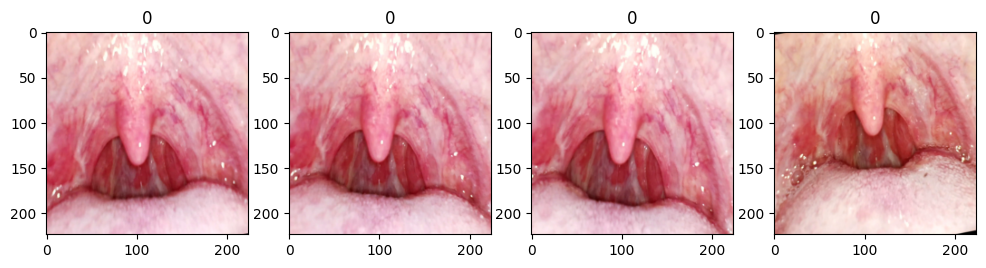

In [2]:
data_dir = '../data/'
train_dir = data_dir + 'images/train/'
val_dir = data_dir + 'images/valid/'

transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_set = ImageFolder(train_dir, transform=transform, target_transform=None)
val_set = ImageFolder(val_dir, transform=transform, target_transform=None)

print(train_set.class_to_idx)

fig, ax = plt.subplots(figsize=(12,8), ncols=4)
for i in range(4):
    image, label = train_set[i]

    # change dimensions to matplotlib order, denormalize, reverse order to get RBG values and clip values to [0,1]
    rgb_img = (image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))[:,:,::-1].clip(0, 1)
    
    ax[i].imshow(rgb_img)
    ax[i].set_title(label)

In [3]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', weights='ResNet50_Weights.DEFAULT')

Using cache found in C:\Users\Tim/.cache\torch\hub\pytorch_vision_v0.6.0


In [4]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(val_loader)

def plot_losses(train_losses, val_losses):
    plt.cla()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    display(plt.gcf())
    clear_output(wait=True)

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    best_loss = np.inf

    for epoch in range(num_epochs):
        avg_train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(avg_train_loss)

        avg_val_loss = validate(model, val_loader, criterion)
        val_losses.append(avg_val_loss)

        plot_losses(train_losses, val_losses)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            model_name = f'ResNet50_pretrained-epoch{epoch}-batch_size{train_loader.batch_size}-lr{optimizer.param_groups[0]["lr"]}.pt'
            torch.save(model, '../models/checkpoint.pt')

    # rename model to include hyperparameters
    os.rename('../models/checkpoint.pt', '../models/' + model_name)

In [5]:
batch_size = 32
learning_rate = 0.001
num_epochs = 10

num_classes = len(train_set.class_to_idx)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
# train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

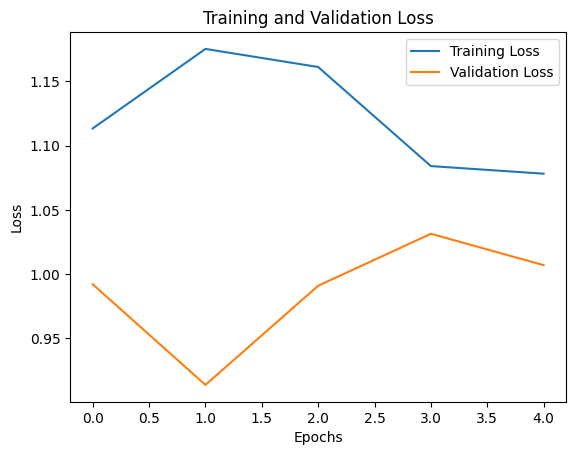

In [6]:
### subset of one to test the code ###

import torch.utils.data as data_utils

num_epochs = 5
indices = torch.arange(1)

train_set2 = data_utils.Subset(train_set, indices)
val_set2 = data_utils.Subset(val_set, indices)

train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val_set2, batch_size=batch_size, shuffle=False)

train(model, train_loader2, val_loader2, criterion, optimizer, num_epochs)